# Project

In [172]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from types import *
from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))


promo_dataset = pd.read_csv("promotion_dataset_subject.csv", encoding='utf-8')
iit_subject_dataset = pd.read_csv('iit_email_subject.csv',encoding='latin1') 
iit_subject_dataset = iit_subject_dataset.drop('Unnamed: 0',1)
promo_dataset = promo_dataset.drop('Unnamed: 0',1)
New_dataset = iit_subject_dataset.append(promo_dataset,ignore_index=True)
New_dataset['Email'] = New_dataset[['From', 'Subject']].apply(lambda x: ''.join(x), axis=1)

New_dataset=New_dataset.fillna(9)

drop_list=[]
for i in range(0,len(New_dataset['Label'])):
    if New_dataset.iloc[i]['Label']==9:
        drop_list.append(i)

New_dataset = New_dataset.drop(drop_list).reset_index(drop=True)
New_dataset.Label = New_dataset.Label.astype(int)
Y = New_dataset.iloc[:,4:5]




In [173]:

print(New_dataset.groupby('Label').count())

        ID  From  Date  Subject  Email
Label                                 
0      751   751   751      751    751
1      571   571   571      571    571
2      456   456   456      456    456


In [175]:
from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = CountVectorizer(max_df=0.5,stop_words='english')#shape=(500, 20928) for Email
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (wnl.lemmatize(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer=stemmed_words,binary=True)#shape=(500, 20936) for Email
X_sparse = vectorizer.fit_transform(New_dataset['Email'])#shape=(561, 1159)
feature_name = vectorizer.get_feature_names()
X = pd.DataFrame(X_sparse.todense()) 

print("feature total number :",len(feature_name))

feature total number : 2958


## Set Classifier and parameter

In [194]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=20, class_prior=None, fit_prior=True)
length_trainset=[]
Budget = 10
seed = 30

## Random Sampling- Lw/oR

In [195]:
def Random_Sampling_lwoR():
    RS_Lwo_R=[]
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.99, random_state = seed)
    for i in range(0,Budget): 
        length_trainset.append(len(X_train))
        nb.fit(X_train, Y_train)
        predicted = nb.predict(X_test)
        RS_Lwo_R.append(nb.score(X_test,Y_test))
        X_train = X_train.append(X_test.iloc[0:5])
        X_test = X_test.drop(X_test.iloc[0:5].index)
        Y_train = Y_train.append(Y_test.iloc[0:5])
        Y_test = Y_test.drop(Y_test.iloc[0:5].index)
Random_Sampling_lwoR()
print("Accuracy: ",RS_Lwo_R)

/Users/YiChen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  [0.47756956274843837, 0.53075170842824604, 0.6950314106225014, 0.68213058419243988, 0.77713957495692132, 0.57603686635944695, 0.60947429231658001, 0.63499420625724223, 0.71295758280069732, 0.76048951048951052]


## Finding_Rationale

In [196]:
Social_rationale_list=["linkedin","indeed","datacamp","ita"]
Primary_rationale_list=["iit","piazza","submission","handshake","collaborate","confirm","confirmation"
,"edu","application","association","apics","hawklink","comsubmission"]
promo_rationale_list=["purchase","special","off","gift","sample","shipping","promotion","left"
,"tonight","sale","new","miss","save","discount","free","last","only"
,"soon","deal","exclusive","today","ends","best","prices","weekend","holiday","now"
,"reward","final","release","clearance","collection","minute"]

Rationale_list = [Primary_rationale_list,promo_rationale_list,Social_rationale_list]
                
def findind_rationale(uncertain_index):
    print("Finding_Rationale: ")
    for i, value in enumerate(uncertain_index):
        label = Y_test.loc[value,'Label']
        for j in range(0,len(feature_name)):
            if X_test.loc[value, j] >0:
                for k,rationale in enumerate(Rationale_list[label]):       
                    if rationale == feature_name[j]:
                        print(New_dataset.iloc[value]['Email'])
                        print("Rationale:",rationale)
                        X_test.set_value(value,j,10)



## Finding_uncertain

In [197]:
def finding_uncertain(X_test):
    print("Uncertain_Email")
    predict_proba = nb.predict_proba(X_test)
    ratio = []
    neural_index = []
    for x in range(0,len(X_test)):
        ratio.append(predict_proba[x,1]/0.3+predict_proba[x,0]/0.3+predict_proba[x,2]/0.3)
    ratio = np.array(ratio)
    neural_row = np.argsort(ratio)[::1][:5]
    for i,value in enumerate(neural_row):
        print(X_test.index[value],New_dataset.iloc[X_test.index[value]]['Email'])
        neural_index.append(X_test.index[value])
    return(neural_index)


## Random Sampling- Lw/R

In [198]:
def Random_Sampling_lwR():
    RS_Lw_R=[]
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.99, random_state = seed)
    for i in range(0,Budget):
        print(i)
        nb.fit(X_train, Y_train)
        predicted = nb.predict(X_test)
        RS_Lw_R.append(nb.score(X_test,Y_test))
        random_list = X_test.iloc[0:5].index
        print(random_list)
        findind_rationale(random_list)
        X_train = X_train.append(X_test.iloc[0:5])
        X_test = X_test.drop(X_test.iloc[0:5].index)
        Y_train = Y_train.append(Y_test.iloc[0:5])
        Y_test = Y_test.drop(Y_test.iloc[0:5].index)

Random_Sampling_lwR()
print("Accuracy: ",RS_Lw_R)

0
Int64Index([1741, 1117, 426, 1080, 1486], dtype='int64')
Finding_Rationale: 


/Users/YiChen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HawkLink <relay@collegiatelink.mail.campuslabs.com>Homecoming - Saturday!
Rationale: hawklink
 Feedback of Assignment 1wk.iit.edu>Re: XLSC04201720 (CS-587-01.17S: Software Project Management):
Rationale: edu
 Feedback of Assignment 1wk.iit.edu>Re: XLSC04201720 (CS-587-01.17S: Software Project Management):
Rationale: iit
"Clinique Online" <clinique@e.clinique.com>pretty sweet! pick 5 free minis with purchase.
Rationale: free
"Clinique Online" <clinique@e.clinique.com>pretty sweet! pick 5 free minis with purchase.
Rationale: purchase
1
Int64Index([197, 706, 314, 1190, 1677], dtype='int64')
Finding_Rationale: 
Bigesh Kuwar <invitations@linkedin.com>Yi Chen, please add me to your LinkedIn network
Rationale: linkedin
"Kristina Zwolfer" <kristina@illinoistech.org>Final Reminder! ITA Student Webinar | Behavioral Based Interviewing
Rationale: ita
CS553 on Piazza <no-reply@piazza.com>Java : command not found on CentOS 7 Instance
Rationale: piazza
CS 584 on Piazza <no-reply@piazza.com>Lecture(01

## Active Learning- Lw/oR

In [199]:
def Active_Learning_lwoR():
    AL_Lwo_R=[]
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.99, random_state = seed)
    for i in range(0,Budget): 
        print(i)
        nb.fit(X_train, Y_train)
        predicted = nb.predict(X_test)
        AL_Lwo_R.append(nb.score(X_test,Y_test))
        uncertain_list = finding_uncertain(X_test)
        for i, value in enumerate(uncertain_list):
            X_train = X_train.append(X_test.loc[value])
            Y_train = Y_train.append(Y_test.loc[value])
            X_test = X_test.drop(value)
            Y_test = Y_test.drop(value)
Active_Learning_lwoR()
print("Accuracy: ",AL_Lwo_R)

0
Uncertain_Email
 <relay@collegiatelink.mail.campuslabs.com>10/3 UI Labs Tour and Presentation
 <handshake@mail.joinhandshake.com>Don't forget about tomorrow's Career Fair Prep Night
632 LinkedIn <news@linkedin.com>A CEO\s response to an employee\s request for a mental health day is going viral. Here\s what people are saying.
1272 "L'Occitane en Provence" <contact@contact.loccitane.com>the fall beauty event ends tonight! get your free gift (worth $59)
813 CS 584 on Piazza <no-reply@piazza.com>Problem in Last Quiz Please explain how we get class 2 for x2?


/Users/YiChen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1
Uncertain_Email
1422 SkinMedix <info@skinmedix.com>it's all on sale! up to an extra 10% off everything you want & more
1696 "L'Occitane en Provence" <contact@contact.loccitane.com>almost gone! our shea butter soaps are just what you need
 skills!ake@mail.joinhandshake.com>Career Fair Prep Night: Practice and refine your communication
862 LinkedIn <news@linkedin.com>Job interviews are utterly useless \ even harmful \ new research finds. Here's what people are saying.
 purchase.e Lauder Online <EsteeLauderOnline@e.esteelauder.com>ends tonight: free 7-piece gift (worth up to $140), with your
2
Uncertain_Email
 <handshake@mail.joinhandshake.com>Submit Your Resume to Fall 2017 Career Fair Companies
 looking for candidates like you.edin.com>Yi Chen: Google, Clarity Solution Group, and Conversant LLC are
1317 "L'Occitane en Provence" <contact@contact.loccitane.com> just in time for fall: discover our new shea butter additions!
917 Career Services at Illinois Tech <careerservices@iit.edu>Lea

## Active Learning- Lw/R

In [200]:
def Active_Learning_lwR():
    AL_Lw_R=[]
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.99, random_state = seed)
    for i in range(0,Budget):
        print(i)
        nb.fit(X_train, Y_train)
        predicted = nb.predict(X_test)
        AL_Lw_R.append(nb.score(X_test,Y_test))
        uncertain_list = finding_uncertain(X_test)
        findind_rationale(uncertain_list)
        for i, value in enumerate(uncertain_list): 
            X_train = X_train.append(X_test.loc[value])
            Y_train = Y_train.append(Y_test.loc[value])
            X_test = X_test.drop(value)
            Y_test = Y_test.drop(value)
Active_Learning_lwR()
print("Accuracy: ",AL_Lw_R)

0
Uncertain_Email
 <relay@collegiatelink.mail.campuslabs.com>10/3 UI Labs Tour and Presentation
 <handshake@mail.joinhandshake.com>Don't forget about tomorrow's Career Fair Prep Night
632 LinkedIn <news@linkedin.com>A CEO\s response to an employee\s request for a mental health day is going viral. Here\s what people are saying.
1272 "L'Occitane en Provence" <contact@contact.loccitane.com>the fall beauty event ends tonight! get your free gift (worth $59)
813 CS 584 on Piazza <no-reply@piazza.com>Problem in Last Quiz Please explain how we get class 2 for x2?
Finding_Rationale: 
 <relay@collegiatelink.mail.campuslabs.com>10/3 UI Labs Tour and Presentation
Rationale: apics
 <relay@collegiatelink.mail.campuslabs.com>10/3 UI Labs Tour and Presentation
Rationale: association


/Users/YiChen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 <handshake@mail.joinhandshake.com>Don't forget about tomorrow's Career Fair Prep Night
Rationale: handshake
LinkedIn <news@linkedin.com>A CEO\s response to an employee\s request for a mental health day is going viral. Here\s what people are saying.
Rationale: linkedin
"L'Occitane en Provence" <contact@contact.loccitane.com>the fall beauty event ends tonight! get your free gift (worth $59)
Rationale: free
"L'Occitane en Provence" <contact@contact.loccitane.com>the fall beauty event ends tonight! get your free gift (worth $59)
Rationale: gift
"L'Occitane en Provence" <contact@contact.loccitane.com>the fall beauty event ends tonight! get your free gift (worth $59)
Rationale: tonight
CS 584 on Piazza <no-reply@piazza.com>Problem in Last Quiz Please explain how we get class 2 for x2?
Rationale: piazza
1
Uncertain_Email
1422 SkinMedix <info@skinmedix.com>it's all on sale! up to an extra 10% off everything you want & more
1696 "L'Occitane en Provence" <contact@contact.loccitane.com>almost go

Career Services at Illinois Tech <careerservices@iit.edu>Tell us what you thought of the spring Career Fair
Rationale: edu
Career Services at Illinois Tech <careerservices@iit.edu>Tell us what you thought of the spring Career Fair
Rationale: iit
 Family Institute for Innovation and Tech Entrepreneurshipw Appointed as Academic Director of the Ed Kaplan
Rationale: edu
 Family Institute for Innovation and Tech Entrepreneurshipw Appointed as Academic Director of the Ed Kaplan
Rationale: iit
 Halloween Partychou@hawk.iit.edu>Fwd: (TSA)Community Partner Confirmation - Chicago Largest Asian
Rationale: confirmation
 Halloween Partychou@hawk.iit.edu>Fwd: (TSA)Community Partner Confirmation - Chicago Largest Asian
Rationale: edu
 Halloween Partychou@hawk.iit.edu>Fwd: (TSA)Community Partner Confirmation - Chicago Largest Asian
Rationale: iit
7
Uncertain_Email
1274 "Kiehl's Since 1851" <kiehls@mail.kiehls-usa.com>your sneak peek of our exciting holiday partnership is here!
 at Illinois Techay@coll

## Compare the result Lw/R & Lw/oR -CountVectorizer

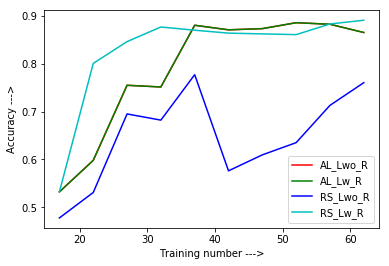

RS_Lwo_R:  [0.47756956274843837, 0.53075170842824604, 0.6950314106225014, 0.68213058419243988, 0.77713957495692132, 0.57603686635944695, 0.60947429231658001, 0.63499420625724223, 0.71295758280069732, 0.76048951048951052]
RS_Lw_R:  [0.53208404315729696, 0.8006833712984055, 0.8463735008566533, 0.87686139747995417, 0.87018954623779432, 0.86405529953917048, 0.86250722125938761, 0.86095017381228278, 0.88320743753631614, 0.89102564102564108]
AL_Lwo_R:  [0.53208404315729696, 0.59794988610478361, 0.75499714448886346, 0.75143184421534936, 0.88052843193566921, 0.87096774193548387, 0.87348353552859614, 0.88586326767091539, 0.88262638001162119, 0.86538461538461542]
AL_Lw_R:  [0.53208404315729696, 0.59794988610478361, 0.75499714448886346, 0.75143184421534936, 0.88052843193566921, 0.87096774193548387, 0.87348353552859614, 0.88586326767091539, 0.88262638001162119, 0.86538461538461542]


In [201]:
import matplotlib.pyplot as plt

plt.plot(length_trainset, AL_Lwo_R,'r-',
        length_trainset,AL_Lw_R,'g-',
        length_trainset,RS_Lwo_R,'b-',
        length_trainset,RS_Lw_R,'c-')

plt.legend(('AL_Lwo_R', 'AL_Lw_R', 'RS_Lwo_R', 'RS_Lw_R'))

plt.xlabel('Training number --->')
plt.ylabel('Accuracy --->')

plt.show()

print("RS_Lwo_R: ",RS_Lwo_R)
print("RS_Lw_R: ",RS_Lw_R)
print("AL_Lwo_R: ",AL_Lwo_R)
print("AL_Lw_R: ",AL_Lw_R)


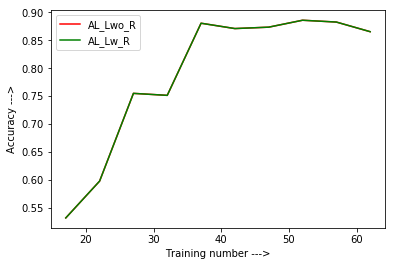

In [202]:
import matplotlib.pyplot as plt

    
plt.plot(length_trainset, AL_Lwo_R,'r-',
        length_trainset,AL_Lw_R,'g-')

plt.legend(('AL_Lwo_R', 'AL_Lw_R'))

plt.xlabel('Training number --->')
plt.ylabel('Accuracy --->')


plt.show()



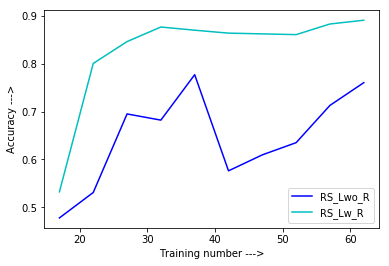

In [203]:
import matplotlib.pyplot as plt

    
plt.plot(length_trainset,RS_Lwo_R,'b-',
        length_trainset,RS_Lw_R,'c-',)

plt.legend(('RS_Lwo_R', 'RS_Lw_R'))

plt.xlabel('Training number --->')
plt.ylabel('Accuracy --->')


plt.show()



In [204]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = CountVectorizer(max_df=0.5,stop_words='english')#shape=(500, 20928) for Email
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(doc):
    return (wnl.lemmatize(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer=stemmed_words)#shape=(500, 20936) for Email
X_sparse = vectorizer.fit_transform(New_dataset['Email'])#shape=(561, 1159)
feature_name = vectorizer.get_feature_names()
X = pd.DataFrame(X_sparse.todense()) 

